In [578]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Load data

In [579]:
raw_data = pd.read_csv('data/Alexa-User-Study-Combined-Data.csv')
raw_data = raw_data[raw_data['include_row_in_pandas'] == 'yes']
for column_name in raw_data.columns:
    if column_name.startswith('Unnamed'):
        del raw_data[column_name]
        
del raw_data['include_row_in_pandas']        
raw_data = raw_data.reset_index(drop=True)

def replace_user_label(original):
    if original == 'Freq User':
        return 'Owners/Freq'
    if original == 'Owner':
        return 'Owners/All'
    return original

raw_data['frequent_user_label'] = raw_data['frequent_user_label'].apply(replace_user_label)
raw_data['owner_label'] = raw_data['owner_label'].apply(replace_user_label)

In [580]:
raw_data.sample(5)

response_id survey_group  is_owner owner_label  is_frequent_users  \
218  R_2q8nvezGhEHrXOr        MTurk       1.0  Owners/All                0.0   
140  R_3JfOXWKanffRtZj        MTurk       1.0  Owners/All                1.0   
89   R_yQJ9odvOcpdsTMl   University       0.0   Not Owner                0.0   
80   R_9GBQGoXUkkV1f0t   University       0.0   Not Owner                0.0   
133  R_2TC1BvwpCvDfpTi        MTurk       0.0   Not Owner                0.0   

    frequent_user_label who_knows_cart who_knows_your_name  \
218       Not Freq User           Both                Both   
140         Owners/Freq           Both                Both   
89        Not Freq User    Only Amazon         Only Amazon   
80        Not Freq User       Not sure                Both   
133       Not Freq User    Only Amazon         Only Amazon   

                       who_knows_your_name_explanation  \
218  Thinks only Amazon originally possesses data a...   
140  Thinks only Amazon originally possesses data a...   
89   Thinks only Amazon originally possesses data a...   
80   Thinks only Amazon originally possesses data a...   
133                                 Unsure/vague/empty   

    every_alexa_programmed_by_amazon  ...  \
218                              Yes  ...   
140                               No  ...   
89                                No  ...   
80                                No  ...   
133                               No  ...   

                                            video_rain  \
218  Non-native Skill (Built by developers unaffili...   
140                     Native Skill (built by Amazon)   
89   Non-native Skill (Built by developers unaffili...   
80                                            Not sure   
133                     Native Skill (built by Amazon)   

                     video_parental audio_wifi audio_problem audio_link  \
218  Native Skill (built by Amazon)       Real          Real       Real   
140  Native Skill (built by Amazon)       Real          Real       Real   
89   Native Skill (built by Amazon)       Real          Real       Real   
80   Native Skill (built by Amazon)       Real          Real   Not real   
133  Native Skill (built by Amazon)       Real          Real   Not real   

    audio_sorry audio_amazon     audio_wifi_explanation  \
218        Real         Real                        NaN   
140        Real         Real                        NaN   
89         Real         Real  Functionality makes sense   
80         Real     Not real  Functionality makes sense   
133        Real     Not real                        NaN   

             audio_amazon_explanation  \
218                               NaN   
140                               NaN   
89          Functionality makes sense   
80   Functionality doesn't make sense   
133                               NaN   

                                    possible_functions  
218  Change the device volume (e.g., ‰ŰĎAlexa, turn...  
140  Change the device volume (e.g., ‰ŰĎAlexa, turn...  
89   Change the device volume (e.g., Š—“Alexa, turn...  
80   Change the device volume (e.g., Š—“Alexa, turn...  
133  Change the device volume (e.g., ‰ŰĎAlexa, turn...  

[5 rows x 29 columns]

# Common functions

In [581]:
def series_count(ss, item):
    return len(ss[ss == item])

In [582]:
# http://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=5

STACKED_COLORS = """

    #1b9e77
    #d95f02
    #7570b3
    #e7298a
    #66a61e

""".split()

print STACKED_COLORS

['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']


## LaTex table

In [583]:
def get_latex_table(
        df, columns=None, hline_before_last_row=False, italicize_others=True):
    """Converts a dataframe into a latex table and returns the string."""

    out_str = ''

    if not columns:
        columns = df.columns

    row_count = len(df)
    i = 0

    for (index, row) in df.iterrows():

        line = []

        if index:
            line.append(str(index))

        for col in columns:
            value = row[col]
            if is_number(value) and abs(value) >= 1000:
                value = "{:,}".format(value)
            value = str(value)
            value = value.replace('%', '\\%')
            line.append(value)

        # hline before last row
        if hline_before_last_row and i + 1 == row_count:
            out_str += '\\midrule \n'

        line = ' & '.join(line)
        out_str += line + ' \\\\ \n'

        i += 1

    if italicize_others:
        out_str = out_str.replace('Others', '\\textit{Others}')

    return out_str


def is_number(v):

    if isinstance(v, basestring):
        return False

    try:
        float(v)
        return True
    except Exception:
        return False


## Stacked DF

In [584]:
def get_stacked_df(answer_column):
    
    graph_df = pd.DataFrame()

    # Everyone
    df = raw_data.copy()
    df['everyone'] = 'Everyone'
    df = pd.pivot_table(df, columns=answer_column, index='everyone', values='response_id', aggfunc='count')
    graph_df = graph_df.append(df)

    # Owners
    df = raw_data[raw_data['owner_label'] == 'Owners/All']
    df = pd.pivot_table(df, columns=answer_column, index='owner_label', values='response_id', aggfunc='count')
    graph_df = graph_df.append(df.iloc[::-1])

    # Freq Users
    df = raw_data[raw_data['frequent_user_label'] == 'Owners/Freq']
    df = pd.pivot_table(df, columns=answer_column, index='frequent_user_label', values='response_id', aggfunc='count')
    graph_df = graph_df.append(df)
    
    graph_df['_total'] = graph_df.apply(lambda row: row.sum(), axis=1)

    graph_df.index = [
        '{} ({})'.format(index_str, int(graph_df.loc[index_str]['_total']))
        for index_str in graph_df.index
    ]
    
    # Find percentage
    for col in graph_df:
        if not col.startswith('_'):
            graph_df[col] = graph_df[col] * 100.0 / graph_df['_total']
    
    del graph_df['_total']
    
    return graph_df.iloc[::-1][graph_df.columns[::-1]].fillna(0)

# Overview of respondents

In [585]:
raw_data[
    (raw_data['owner_label'] == 'Not Owner') &
    (raw_data['frequent_user_label'] == 'Freq Owner') 
]

Empty DataFrame
Columns: [response_id, survey_group, is_owner, owner_label, is_frequent_users, frequent_user_label, who_knows_cart, who_knows_your_name, who_knows_your_name_explanation, every_alexa_programmed_by_amazon, can_invoke_skill_grubhub, can_invoke_skill_nytimes, can_invoke_skill_iphone, can_invoke_skill_quit, can_invoke_skill_go_away, can_invoke_skill_bug, video_joke, video_jeopardy, video_baseball, video_rain, video_parental, audio_wifi, audio_problem, audio_link, audio_sorry, audio_amazon, audio_wifi_explanation, audio_amazon_explanation, possible_functions]
Index: []

[0 rows x 29 columns]

                  Owners/Freq  Owners/All  Everyone
MTurk (134)                41         101       134
University (103)            0          21       103


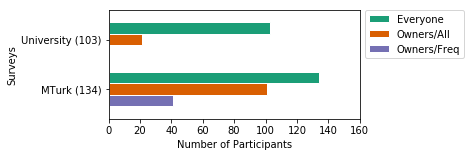

In [586]:
df = pd.DataFrame()

g = raw_data.groupby('survey_group')
df['Everyone'] = g['response_id'].nunique()
df['Owners/All'] = g['owner_label'].apply(lambda ss: series_count(ss, 'Owners/All'))
df['Owners/Freq'] = g['frequent_user_label'].apply(lambda ss: series_count(ss, 'Owners/Freq'))

df = df[df.columns[::-1]]

plt.close('all')
plt.figure(figsize=(4.5, 2))
ax = plt.subplot(1, 1, 1)

df.index = ['{} ({})'.format(index_name, df.loc[index_name]['Everyone']) for index_name in df.index]

df.plot.barh(ax=ax, width=0.7, colors=STACKED_COLORS[0:3][::-1], edgecolor='white',)

# reverse the order of legend
handles, labels = ax.get_legend_handles_labels()

ax.set_xlabel('Number of Participants')
ax.set_ylabel('Surveys')

ax.set_xlim(0, 160)

lgd = plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

print df.to_string()

plt.savefig('figures/sample_features.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Everything Alexa says is programmed by Amazon

every_alexa_programmed_by_amazon        Yes         No
Owners/Freq (41)                  53.658537  46.341463
Owners/All (122)                  68.852459  31.147541
Everyone (237)                    62.447257  37.552743


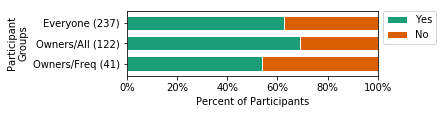

In [587]:
graph_df = get_stacked_df('every_alexa_programmed_by_amazon')

plt.close('all')
plt.figure(figsize=(4.5, 1.2))
ax = plt.subplot(1, 1, 1)

# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=5
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('Percent of Participants')
ax.set_ylabel('Participant\nGroups')
ax.set_xlim(0, 100)

print graph_df.to_string()

plt.savefig('figures/programmed_by_amazon.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Video 1A & 1B


who_knows_cart    Only Amazon  Only other parties       Both  Not sure
Owners/Freq (41)    65.853659            4.878049  26.829268  2.439024
Owners/All (122)    53.278689            2.459016  36.885246  7.377049
Everyone (237)      46.835443            1.687764  42.194093  9.282700

who_knows_your_name  Only Amazon  Only other parties       Both   Not sure
Owners/Freq (41)       56.097561            2.439024  29.268293  12.195122
Owners/All (122)       44.262295            2.459016  42.622951  10.655738
Everyone (237)         41.350211            1.265823  43.037975  14.345992


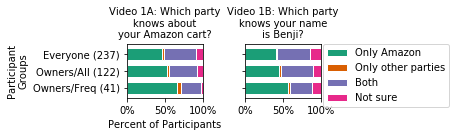

In [588]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 2))

####

ax = ax_list[0]

graph_df = get_stacked_df('who_knows_cart')
graph_df = graph_df[['Only Amazon', 'Only other parties', 'Both', 'Not sure']]
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Video 1A: Which party\nknows about\nyour Amazon cart?', fontsize=10)
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('who_knows_your_name')
graph_df = graph_df[['Only Amazon', 'Only other parties', 'Both', 'Not sure']]
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('Video 1B: Which party\nknows your name\nis Benji?', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/video_1a_1b.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Video 1B explanation

                  Amazon not sharing  Amazon sharing  3rd-party skill  Vague/empty
Owners/Freq (41)           19.512195       24.390244        12.195122    43.902439
Owners/All (121)           23.140496       15.702479        19.008264    42.148760
Everyone (236)             27.118644       11.016949        25.000000    36.864407


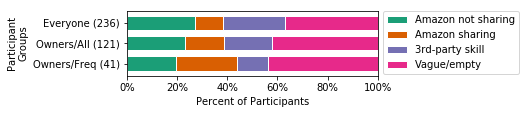

In [589]:
graph_df = get_stacked_df('who_knows_your_name_explanation')

def relabel(expl):
    if 'Unsure' in expl:
        return 'Vague/empty'
    if 'skill' in expl:
        return '3rd-party skill'
    if 'DOES share' in expl:
        return 'Amazon sharing'
    if 'DOES NOT' in expl:
        return 'Amazon not sharing'
    return 'ERROR'

graph_df.columns = [relabel(expl) for expl in graph_df.columns][::-1]

plt.close('all')
plt.figure(figsize=(4.5, 1.2))
ax = plt.subplot(1, 1, 1)

# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=5
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('Percent of Participants')
ax.set_ylabel('Participant\nGroups')
ax.set_xlim(0, 100)

print graph_df.to_string()

plt.savefig('figures/video_1b_reason.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [590]:
graph_df = pd.pivot_table(
    raw_data, 
    index='who_knows_your_name_explanation',
    columns='who_knows_your_name',
    values='response_id',
    aggfunc='count'
).fillna(0)

graph_df['_total'] = graph_df.apply(lambda row: row.sum(), axis=1)

def relabel(expl):
    if 'Unsure' in expl:
        return 'Unsure'
    if 'skill' in expl:
        return '3rd-party skill'
    if 'DOES share' in expl:
        return 'Amazon shares'
    if 'DOES NOT' in expl:
        return 'Amazon not shares'
    return 'ERROR'
    
graph_df.index = [
    '{} ({})'.format(relabel(index_str), int(graph_df.loc[index_str]['_total']))
    for index_str in graph_df.index
]

# Find percentage
for col in graph_df:
    if not col.startswith('_'):
        graph_df[col] = (graph_df[col] * 100.0 / graph_df['_total']).round(1)

graph_df = graph_df.apply(lambda c: c.apply(lambda v: '{}%'.format(v)))
        
del graph_df['_total']

cols = list(graph_df.columns)
cols.remove('Not sure')
cols += ['Not sure']
graph_df = graph_df[cols]

print get_latex_table(graph_df)

graph_df

Amazon not shares (87) & 12.6\% & 85.1\% & 0.0\% & 2.3\% \\ 
Amazon shares (59) & 89.8\% & 5.1\% & 1.7\% & 3.4\% \\ 
3rd-party skill (26) & 69.2\% & 3.8\% & 3.8\% & 23.1\% \\ 
Unsure (64) & 29.7\% & 31.2\% & 1.6\% & 37.5\% \\ 



who_knows_your_name      Both Only Amazon Only other parties Not sure
Amazon not shares (87)  12.6%       85.1%               0.0%     2.3%
Amazon shares (59)      89.8%        5.1%               1.7%     3.4%
3rd-party skill (26)    69.2%        3.8%               3.8%    23.1%
Unsure (64)             29.7%       31.2%               1.6%    37.5%

# Video 3A-3E


video_joke        Native skill  3rd-party skill   Not sure
Owners/Freq (41)     80.487805        14.634146   4.878049
Owners/All (122)     78.688525        13.114754   8.196721
Everyone (237)       75.527426        11.814346  12.658228

                  Native skill  3rd-party skill  Not sure
Owners/Freq (41)      7.317073        92.682927  0.000000
Owners/All (122)     10.655738        86.885246  2.459016
Everyone (237)       13.924051        79.746835  6.329114

video_baseball    Native skill  3rd-party skill   Not sure
Owners/Freq (41)     75.609756        21.951220   2.439024
Owners/All (122)     58.196721        33.606557   8.196721
Everyone (237)       55.696203        33.333333  10.970464

video_rain        Native skill  3rd-party skill   Not sure
Owners/Freq (41)     51.219512        31.707317  17.073171
Owners/All (122)     51.639344        37.704918  10.655738
Everyone (237)       48.101266        37.974684  13.924051

video_parental    Native skill  3rd-party skill  Not su

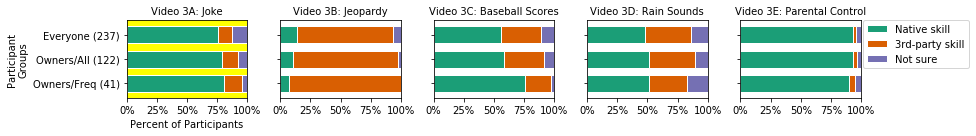

In [591]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=5, figsize=(12, 2))

cols = [
    'Native Skill (built by Amazon)', 
    'Non-native Skill (Built by developers unaffiliated with Amazon)', 
    'Not sure'
]

renamed_cols = [
    'Native skill', '3rd-party skill', 'Not sure'
]

rename_dict = dict(zip(cols, renamed_cols))

####

ax = ax_list[0]

graph_df = get_stacked_df('video_joke')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Video 3A: Joke', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('video_jeopardy')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Video 3B: Jeopardy', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[2]

graph_df = get_stacked_df('video_baseball')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Video 3C: Baseball Scores', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[3]

graph_df = get_stacked_df('video_rain')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Video 3D: Rain Sounds', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[4]

graph_df = get_stacked_df('video_parental')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('Video 3E: Parental Control', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/video_3a_3e.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Audio 3A-3E


audio_wifi             Real   Not real
Owners/Freq (41)  92.682927   7.317073
Owners/All (122)  90.983607   9.016393
Everyone (237)    88.607595  11.392405

audio_problem          Real   Not real
Owners/Freq (41)  75.609756  24.390244
Owners/All (122)  75.409836  24.590164
Everyone (237)    73.417722  26.582278

audio_link             Real   Not real
Owners/Freq (41)  70.731707  29.268293
Owners/All (122)  72.950820  27.049180
Everyone (235)    74.893617  25.106383

audio_sorry            Real   Not real
Owners/Freq (41)  90.243902   9.756098
Owners/All (122)  86.885246  13.114754
Everyone (237)    86.497890  13.502110

audio_amazon           Real   Not real
Owners/Freq (41)  73.170732  26.829268
Owners/All (122)  78.688525  21.311475
Everyone (237)    77.637131  22.362869


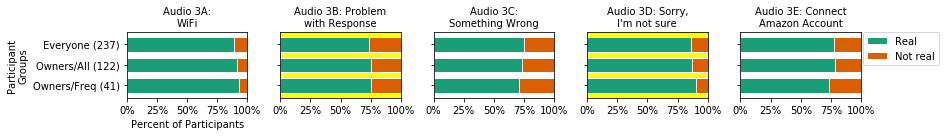

In [592]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=5, figsize=(12, 2))

cols = [
    'Real', 
    'Not real'
]

renamed_cols = cols

rename_dict = dict(zip(cols, renamed_cols))

####

ax = ax_list[0]

graph_df = get_stacked_df('audio_wifi')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Audio 3A:\nWiFi', fontsize=10)
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('audio_problem')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Audio 3B: Problem\nwith Response', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[2]

graph_df = get_stacked_df('audio_link')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Audio 3C:\nSomething Wrong', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[3]

graph_df = get_stacked_df('audio_sorry')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Audio 3D: Sorry,\nI\'m not sure', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[4]

graph_df = get_stacked_df('audio_amazon')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('Audio 3E: Connect\nAmazon Account', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/audio_3a_3e.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Audio 3A & 3E explanation


audio_wifi_explanation  Functionality okay  Functionality not okay  Sounds real  Sounds fake  Vague/empty
Owners/All (21)                   9.523810                4.761905    42.857143     4.761905    38.095238
Everyone (103)                   36.893204                3.883495    31.067961     3.883495    24.271845

audio_amazon_explanation  Functionality okay  Functionality not okay  Sounds real  Sounds fake  Vague/empty
Owners/All (21)                    33.333333               14.285714     9.523810     9.523810    33.333333
Everyone (103)                     41.747573               13.592233    15.533981     6.796117    22.330097


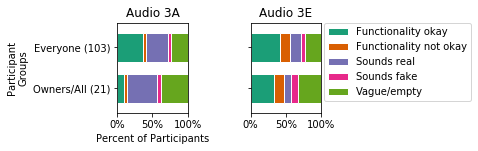

In [599]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 2.2))

cols_3A = [
    'Functionality makes sense',
    "Functionality doesn't make sense",
    'Sounds real/Heard it before',
    "Doesn't sound real/Haven't heard it before",
    'Empty/vague',    
]

cols_3E = [ 
    'Functionality makes sense',    
    "Functionality doesn't make sense",    
    'Sounds real', 
    'Sounds fake',
    'Vague/empty'    
]

renamed_cols = [
    'Functionality okay',
    'Functionality not okay',
    'Sounds real',
    'Sounds fake',
    'Vague/empty'
]

####

ax = ax_list[0]

graph_df = get_stacked_df('audio_wifi_explanation')
graph_df = graph_df[cols_3A].rename(columns=dict(zip(cols_3A, renamed_cols)))

graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Audio 3A')
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('audio_amazon_explanation')
graph_df = graph_df[cols_3E].rename(columns=dict(zip(cols_3E, renamed_cols)))


graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('Audio 3E')
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/audio_3a_3e_reason.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Invocation phrases


                        Yes         No  Not Sure
Owners/Freq (41)  92.682927   7.317073  0.000000
Owners/All (122)  81.967213  13.114754  4.918033
Everyone (237)    86.075949   9.704641  4.219409

can_invoke_skill_nytimes        Yes         No  Not Sure
Owners/Freq (41)          87.804878   9.756098  2.439024
Owners/All (122)          80.327869  11.475410  8.196721
Everyone (237)            82.278481  10.126582  7.594937

can_invoke_skill_iphone        Yes         No   Not Sure
Owners/Freq (41)         58.536585  29.268293  12.195122
Owners/All (122)         54.918033  29.508197  15.573770
Everyone (237)           56.540084  28.691983  14.767932

                        Yes         No  Not Sure
Owners/Freq (41)  53.658537  46.341463  0.000000
Owners/All (121)  51.239669  42.975207  5.785124
Everyone (236)    50.423729  42.796610  6.779661

can_invoke_skill_go_away        Yes         No   Not Sure
Owners/Freq (41)          34.146341  56.097561   9.756098
Owners/All (122)          34.42

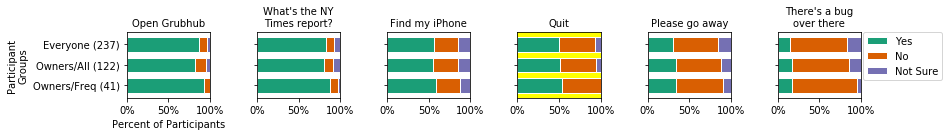

In [594]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=6, figsize=(12, 2))

cols = [
    'Yes', 
    'No',
    'Not Sure'
]

renamed_cols = cols

rename_dict = dict(zip(cols, renamed_cols))

####

ax = ax_list[0]

graph_df = get_stacked_df('can_invoke_skill_grubhub')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Open Grubhub', fontsize=10)
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('can_invoke_skill_nytimes')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('What\'s the NY\nTimes report?', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[2]

graph_df = get_stacked_df('can_invoke_skill_iphone')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Find my iPhone', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[3]

graph_df = get_stacked_df('can_invoke_skill_quit')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Quit', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[4]

graph_df = get_stacked_df('can_invoke_skill_go_away')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Please go away', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[5]

graph_df = get_stacked_df('can_invoke_skill_bug')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('There\'s a bug\nover there', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/invocation.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Possible functions

In [595]:
# Add columns to original data

def check_text(text):
    return raw_data['possible_functions'].apply(lambda s: 'Yes' if text in s else 'No')

raw_data['function_volume'] = check_text('Change the device volume')
raw_data['function_mute'] = check_text('Mute the device')
raw_data['function_wifi'] = check_text('Check wifi connection')
raw_data['function_order'] = check_text('Order items on Amazon')
raw_data['function_parental'] = check_text('parental control')
raw_data['function_account'] = check_text('Amazon account password')
raw_data['function_off'] = check_text('Turn off the device')


function_volume         Yes        No
Owners/Freq (41)  97.560976  2.439024
Owners/All (122)  95.081967  4.918033
Everyone (237)    96.202532  3.797468

function_mute           Yes        No
Owners/Freq (41)  92.682927  7.317073
Owners/All (122)  90.163934  9.836066
Everyone (237)    90.717300  9.282700

function_wifi           Yes         No
Owners/Freq (41)  73.170732  26.829268
Owners/All (122)  73.770492  26.229508
Everyone (237)    79.324895  20.675105

function_account        Yes         No
Owners/Freq (41)   7.317073  92.682927
Owners/All (122)  12.295082  87.704918
Everyone (237)    11.392405  88.607595

function_order          Yes        No
Owners/Freq (41)  97.560976  2.439024
Owners/All (122)  93.442623  6.557377
Everyone (237)    91.983122  8.016878

function_off            Yes         No
Owners/Freq (41)  73.170732  26.829268
Owners/All (122)  76.229508  23.770492
Everyone (237)    81.434599  18.565401

function_parental        Yes         No
Owners/Freq (41)   75.609756 

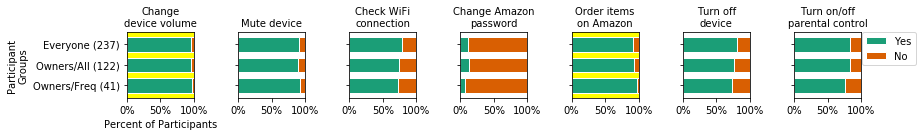

In [598]:
plt.close('all')

f, ax_list = plt.subplots(nrows=1, ncols=7, figsize=(12, 2))

cols = [
    'Yes', 
    'No'
]

renamed_cols = cols

rename_dict = dict(zip(cols, renamed_cols))

####

ax = ax_list[0]

graph_df = get_stacked_df('function_volume')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Change\ndevice volume', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.set_xlabel('Percent of Participants')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

####

ax = ax_list[1]

graph_df = get_stacked_df('function_mute')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Mute device', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[2]

graph_df = get_stacked_df('function_wifi')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Check WiFi\nconnection', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[3]

graph_df = get_stacked_df('function_account')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Change Amazon\npassword', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[4]

graph_df = get_stacked_df('function_order')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Order items\non Amazon', fontsize=10)
ax.set_facecolor('yellow')
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[5]

graph_df = get_stacked_df('function_off')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7, legend=None)
print ''
print graph_df.to_string()

ax.set_title('Turn off\ndevice', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

ax = ax_list[6]

graph_df = get_stacked_df('function_parental')
graph_df = graph_df[cols].rename(columns=rename_dict)
graph_df.plot.barh(ax=ax, stacked=True, color=STACKED_COLORS, edgecolor='white', width=0.7)
print ''
print graph_df.to_string()

ax.set_title('Turn on/off\nparental control', fontsize=10)
ax.set_xlim(0, 100)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{}%'.format(int(x)))
)

ax.set_yticklabels([])

####

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


ax_list[0].set_ylabel('Participant\nGroups')

plt.savefig('figures/functions.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Temp